In [93]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [94]:
# Create Tensors to hold input and outputs.
beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,4]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,2]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,3]),np.zeros(90))

beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [95]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


tensor(0.2181, dtype=torch.float64)

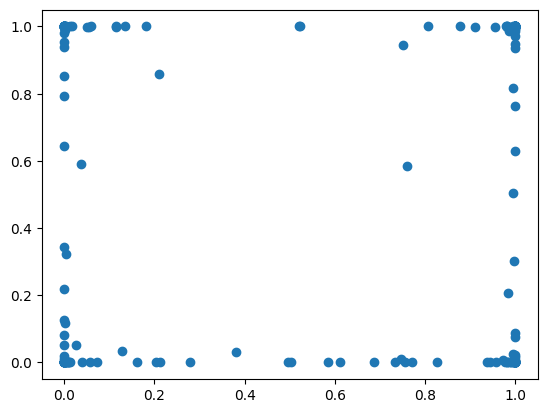

In [96]:
plt.scatter(sigmoid(x3@beta_3).squeeze(),sigmoid(x1@beta_1).squeeze())
sigmoid(x3@beta_3).squeeze().cov()

In [97]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [98]:
################## first step##################

prior=[1,2,3,4,5,6,7]
# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lr,ga,lambda1,lambda2= config["lr"], config["ga"], config["lambda1"],config["lambda2"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params,
                                           model_2_all_linear2_params,model_2_all_linear3_params,
                                           model_3_all_linear2_params,model_3_all_linear3_params),0)
            non_prior=np.setdiff1d([i for i in range(all_linear1_params.shape[1])],prior)
            
            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,non_prior],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear23_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3= model_3(train_x3[idx_test])
        
        test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lr": tune.choice([0.4,0.6,0.8]),
        "ga": tune.choice([0.2]),
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003])
    }


    result = tune.run(
        train_model,  
        config=config,
        num_samples=32)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,ga,lambda1,lambda2,lr,iter,total time (s),my_test_BCE_loss
train_model_bb59e_00000,TERMINATED,10.224.0.12:23643,0.2,0.05,0.001,0.8,1,14.5189,1.46534
train_model_bb59e_00001,TERMINATED,10.224.0.12:24077,0.2,0.05,0.001,0.4,1,11.8784,1.54206
train_model_bb59e_00002,TERMINATED,10.224.0.12:24080,0.2,0.04,0.003,0.6,1,13.9309,1.27708
train_model_bb59e_00003,TERMINATED,10.224.0.12:24082,0.2,0.04,0.001,0.8,1,12.1331,1.46383
train_model_bb59e_00004,TERMINATED,10.224.0.12:24084,0.2,0.05,0.003,0.8,1,13.3308,1.29853
train_model_bb59e_00005,TERMINATED,10.224.0.12:24087,0.2,0.05,0.001,0.6,1,14.1008,1.46807
train_model_bb59e_00006,TERMINATED,10.224.0.12:24085,0.2,0.04,0.001,0.4,1,12.9401,1.53158
train_model_bb59e_00007,TERMINATED,10.224.0.12:24089,0.2,0.05,0.001,0.4,1,13.7305,1.54206
train_model_bb59e_00008,TERMINATED,10.224.0.12:24091,0.2,0.03,0.001,0.6,1,13.0559,1.53192
train_model_bb59e_00009,TERMINATED,10.224.0.12:24092,0.2,0.05,0.003,0.8,1,13.0297,1.29853


Result for train_model_bb59e_00000:
  date: 2022-10-17_19-13-47
  done: false
  experiment_id: bbf16fbbb36e4babb49ab7fc74455e94
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4653350830078125
  node_ip: 10.224.0.12
  pid: 23643
  time_since_restore: 14.518917322158813
  time_this_iter_s: 14.518917322158813
  time_total_s: 14.518917322158813
  timestamp: 1666005227
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb59e_00000
  warmup_time: 0.003171682357788086
  
Result for train_model_bb59e_00000:
  date: 2022-10-17_19-13-47
  done: true
  experiment_id: bbf16fbbb36e4babb49ab7fc74455e94
  experiment_tag: 0_ga=0.2000,lambda1=0.0500,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4653350830078125
  node_ip: 10.224.0.12
  pid: 23643
  time_since_restore: 14.518917322158813
  time_this_iter_s: 14.518917322158813
  time_total_s: 14.518917322158813
  timestamp: 1666005227
  times

Result for train_model_bb59e_00003:
  date: 2022-10-17_19-13-49
  done: true
  experiment_id: 269759893ca849789148476996ba7be3
  experiment_tag: 3_ga=0.2000,lambda1=0.0400,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4638306379318238
  node_ip: 10.224.0.12
  pid: 24082
  time_since_restore: 12.133090019226074
  time_this_iter_s: 12.133090019226074
  time_total_s: 12.133090019226074
  timestamp: 1666005229
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb59e_00003
  warmup_time: 0.011287927627563477
  
Result for train_model_bb59e_00024:
  date: 2022-10-17_19-13-49
  done: false
  experiment_id: ba015d87b592454b8afcfd53254ba88a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5319244861602783
  node_ip: 10.224.0.12
  pid: 24123
  time_since_restore: 12.097599506378174
  time_this_iter_s: 12.097599506378174
  time_total_s: 12.097599506378174
  timestamp: 1666005229
  times

Result for train_model_bb59e_00004:
  date: 2022-10-17_19-13-50
  done: false
  experiment_id: 3933a585cac1463a8f6148cae8962a04
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.298527145385742
  node_ip: 10.224.0.12
  pid: 24084
  time_since_restore: 13.3307945728302
  time_this_iter_s: 13.3307945728302
  time_total_s: 13.3307945728302
  timestamp: 1666005230
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb59e_00004
  warmup_time: 0.004435539245605469
  
Result for train_model_bb59e_00004:
  date: 2022-10-17_19-13-50
  done: true
  experiment_id: 3933a585cac1463a8f6148cae8962a04
  experiment_tag: 4_ga=0.2000,lambda1=0.0500,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.298527145385742
  node_ip: 10.224.0.12
  pid: 24084
  time_since_restore: 13.3307945728302
  time_this_iter_s: 13.3307945728302
  time_total_s: 13.3307945728302
  timestamp: 1666005230
  timesteps_since_res

Result for train_model_bb59e_00020:
  date: 2022-10-17_19-13-51
  done: false
  experiment_id: 940e5b3e209a49cb990c4804c4432ad9
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4873037576675414
  node_ip: 10.224.0.12
  pid: 24115
  time_since_restore: 13.585875511169434
  time_this_iter_s: 13.585875511169434
  time_total_s: 13.585875511169434
  timestamp: 1666005231
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb59e_00020
  warmup_time: 0.004349231719970703
  
Result for train_model_bb59e_00020:
  date: 2022-10-17_19-13-51
  done: true
  experiment_id: 940e5b3e209a49cb990c4804c4432ad9
  experiment_tag: 20_ga=0.2000,lambda1=0.0500,lambda2=0.0020,lr=0.4000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4873037576675414
  node_ip: 10.224.0.12
  pid: 24115
  time_since_restore: 13.585875511169434
  time_this_iter_s: 13.585875511169434
  time_total_s: 13.585875511169434
  timestamp: 1666005231
  time

2022-10-17 19:13:51,989	INFO tune.py:758 -- Total run time: 21.19 seconds (21.00 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
bb59e_00000          1.465335         14.518917  True            None   
bb59e_00001          1.542062         11.878438  True            None   
bb59e_00002          1.277077         13.930891  True            None   
bb59e_00003          1.463831         12.133090  True            None   
bb59e_00004          1.298527         13.330795  True            None   
bb59e_00005          1.468065         14.100827  True            None   
bb59e_00006          1.531584         12.940095  True            None   
bb59e_00007          1.542062         13.730473  True            None   
bb59e_00008          1.531924         13.055890  True            None   
bb59e_00009          1.298527         13.029708  True            None   
bb59e_00010          1.422535         12.326703  True            N

In [99]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

Best trial final validation loss: 1.2323497176170348


{'lr': 0.8, 'ga': 0.2, 'lambda1': 0.04, 'lambda2': 0.003}

In [100]:
################## second step##################

#0.4,0.4
# set hyperparamters
prior=[1,2,3,4,5,6,7]
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
lambda1,lambda2,lr,ga=final_lambda["lambda1"],final_lambda["lambda2"],final_lambda["lr"],final_lambda["ga"]
learning_rate=lr
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])

    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])

    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, 
                                     model_2_all_linear2_params,model_2_all_linear3_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params),0)
    non_prior=np.setdiff1d([i for i in range(all_linear1_params.shape[1])],prior)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,non_prior],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear23_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.1798, grad_fn=<AddBackward0>)

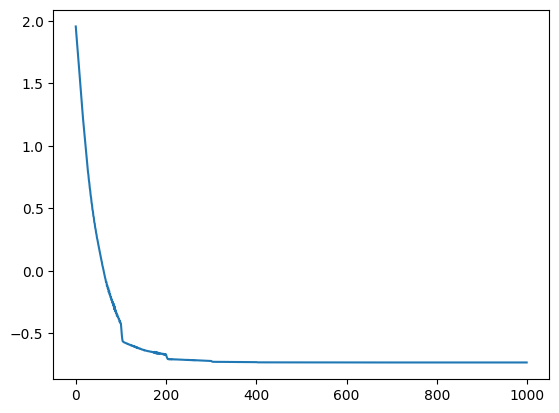

In [101]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [102]:
################## Y_prior##################


y_prior_1= (model_1(train_x1)[0]).detach().squeeze()

y_prior_2= (model_2(train_x2)[0]).detach().squeeze()

y_prior_3= (model_3(train_x3)[0]).detach().squeeze()

BCE_loss_1 = loss_fn(y_prior_1,train_y1)
BCE_loss_2 = loss_fn(y_prior_2, train_y2)
BCE_loss_3 = loss_fn(y_prior_3, train_y3)
BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
BCE_loss
BCE_loss_1
BCE_loss_2
BCE_loss_3

tensor(0.1798)

tensor(0.0795)

tensor(0.0149)

tensor(0.0853)

In [103]:
y_p_1= (model_1(train_x1)[0]>0.5).clone().int()
t_p_1= train_y1.reshape(-1,1).int()

y_p_2= (model_2(train_x2)[0]>0.5).clone().int()
t_p_2= train_y2.reshape(-1,1).int()

y_p_3= (model_3(train_x3)[0]>0.5).clone().int()
t_p_3= train_y3.reshape(-1,1).int()

confusion_matrix(t_p_1,y_p_1)
confusion_matrix(t_p_2,y_p_2)
confusion_matrix(t_p_3,y_p_3)

array([[90,  0],
       [ 3, 67]])

array([[88,  0],
       [ 0, 72]])

array([[69,  0],
       [ 2, 89]])

In [104]:
################## third step##################

#no prior
prior=0
# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3



# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)
    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)
    
    
    lambda1,lambda2,eta,ga,lr= config["lambda1"], config["lambda2"],config["eta"],config["ga"],config["lr"]
    inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
    targets_1=(1-eta)*train_y1+eta*y_prior_1
    targets_2=(1-eta)*train_y2+eta*y_prior_2
    targets_3=(1-eta)*train_y3+eta*y_prior_3
    
    
    
    sum_test_BCE_loss=0
    sum_tGM=0
    for idx_train,idx_test in kf.split(inputs_1):
       
        
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
            
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
# #         test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
# #         test_BCE_loss_2 = loss_fn(test_out_2, targets_1[idx_test].reshape(-1,1))
# #         test_BCE_loss_3 = loss_fn(test_out_3, targets_1[idx_test].reshape(-1,1))

#         test_BCE_loss_1 = loss_fn(test_out_1, train_y1[idx_test].reshape(-1,1))
#         test_BCE_loss_2 = loss_fn(test_out_2, train_y2[idx_test].reshape(-1,1))
#         test_BCE_loss_3 = loss_fn(test_out_3, train_y3[idx_test].reshape(-1,1))
        
#         test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
#         sum_test_BCE_loss+=test_BCE_loss.item()

#     #print("loss: ",)
#     tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)

        test_prediction_1= (model_1(train_x1[idx_test])[0]>0.5).clone().int()
        test_target_1= train_y1[idx_test].reshape(-1,1).int()

        test_prediction_2= (model_2(train_x2[idx_test])[0]>0.5).clone().int()
        test_target_2= train_y2[idx_test].reshape(-1,1).int()

        test_prediction_3= (model_3(train_x3[idx_test])[0]>0.5).clone().int()
        test_target_3= train_y3[idx_test].reshape(-1,1).int()

        test_prediction=np.append(test_prediction_1,test_prediction_2)
        test_prediction=np.append(test_prediction,test_prediction_3)
        test_prediction=test_prediction.tolist()

        test_target=np.append(test_target_1,test_target_2)
        test_target=np.append(test_target,test_target_3)
        test_target=test_target.tolist()

        final_matrix=confusion_matrix(test_target,test_prediction)
        tTPR=recall_score(test_target,test_target)#TPR
        tTNR=final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
        tGM=math.sqrt(tTPR*tTNR)

        sum_tGM+=tGM

    tune.report(my_test_sum_tGM=sum_tGM/split_num)
     
        
if __name__ == '__main__':
#     inputs_1,targets_1 = train_x1,train_y1
#     inputs_2,targets_2 = train_x2,train_y2
#     inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
        "lr": tune.choice([0.4,0.6,0.8]),
        "ga": tune.choice([0.3]),
        "eta": tune.choice([0.06,0.09,0.1,0.12,0.15,0.17,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
    }


    result = tune.run(
        train_model,  
        config=config,
        num_samples=96)
    
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,eta,ga,lambda1,lambda2,lr,iter,total time (s),my_test_sum_tGM
train_model_dbe93_00000,TERMINATED,10.224.0.12:25563,0.15,0.3,0.03,0.003,0.4,1,16.1166,0.890233
train_model_dbe93_00001,TERMINATED,10.224.0.12:26116,0.75,0.3,0.05,0.003,0.4,1,15.1781,0.895228
train_model_dbe93_00002,TERMINATED,10.224.0.12:26118,0.06,0.3,0.05,0.001,0.8,1,15.6825,0.917859
train_model_dbe93_00003,TERMINATED,10.224.0.12:26120,0.09,0.3,0.03,0.001,0.8,1,15.7402,0.894599
train_model_dbe93_00004,TERMINATED,10.224.0.12:26122,0.25,0.3,0.04,0.002,0.4,1,14.0577,0.890917
train_model_dbe93_00005,TERMINATED,10.224.0.12:26124,0.75,0.3,0.04,0.003,0.6,1,13.6341,0.913787
train_model_dbe93_00006,TERMINATED,10.224.0.12:26126,0.12,0.3,0.03,0.002,0.4,1,15.0363,0.885519
train_model_dbe93_00007,TERMINATED,10.224.0.12:26128,0.55,0.3,0.05,0.001,0.8,1,14.7293,0.937446
train_model_dbe93_00008,TERMINATED,10.224.0.12:26130,0.15,0.3,0.03,0.001,0.6,1,13.7963,0.893275
train_model_dbe93_00009,TERMINATED,10.224.0.12:26132,0.65,0.3,0.05,0.002,0.6,1,15.5551,0.928724


Result for train_model_dbe93_00000:
  date: 2022-10-17_19-14-44
  done: false
  experiment_id: deea4070952b42e0a76ffda173ca2622
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8902325712856966
  node_ip: 10.224.0.12
  pid: 25563
  time_since_restore: 16.116616010665894
  time_this_iter_s: 16.116616010665894
  time_total_s: 16.116616010665894
  timestamp: 1666005284
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dbe93_00000
  warmup_time: 0.003751516342163086
  
Result for train_model_dbe93_00000:
  date: 2022-10-17_19-14-44
  done: true
  experiment_id: deea4070952b42e0a76ffda173ca2622
  experiment_tag: 0_eta=0.1500,ga=0.3000,lambda1=0.0300,lambda2=0.0030,lr=0.4000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8902325712856966
  node_ip: 10.224.0.12
  pid: 25563
  time_since_restore: 16.116616010665894
  time_this_iter_s: 16.116616010665894
  time_total_s: 16.116616010665894
  timestamp: 166600528

Result for train_model_dbe93_00017:
  date: 2022-10-17_19-14-46
  done: false
  experiment_id: c88e1db56c624242b49e2724dca073a2
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8831544174275467
  node_ip: 10.224.0.12
  pid: 26159
  time_since_restore: 14.800849437713623
  time_this_iter_s: 14.800849437713623
  time_total_s: 14.800849437713623
  timestamp: 1666005286
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dbe93_00017
  warmup_time: 0.009172439575195312
  
Result for train_model_dbe93_00014:
  date: 2022-10-17_19-14-46
  done: false
  experiment_id: 8a59302226714a75b458f37ff4f1f711
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9373204357653535
  node_ip: 10.224.0.12
  pid: 26143
  time_since_restore: 14.72446584701538
  time_this_iter_s: 14.72446584701538
  time_total_s: 14.72446584701538
  timestamp: 1666005286
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dbe93_00014
  wa

Result for train_model_dbe93_00002:
  date: 2022-10-17_19-14-47
  done: false
  experiment_id: 3dbd75af79e5404e9befafc87be854ee
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9178585349397265
  node_ip: 10.224.0.12
  pid: 26118
  time_since_restore: 15.682515144348145
  time_this_iter_s: 15.682515144348145
  time_total_s: 15.682515144348145
  timestamp: 1666005287
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dbe93_00002
  warmup_time: 0.007485389709472656
  
Result for train_model_dbe93_00002:
  date: 2022-10-17_19-14-47
  done: true
  experiment_id: 3dbd75af79e5404e9befafc87be854ee
  experiment_tag: 2_eta=0.0600,ga=0.3000,lambda1=0.0500,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9178585349397265
  node_ip: 10.224.0.12
  pid: 26118
  time_since_restore: 15.682515144348145
  time_this_iter_s: 15.682515144348145
  time_total_s: 15.682515144348145
  timestamp: 166600528

Result for train_model_dbe93_00025:
  date: 2022-10-17_19-14-47
  done: false
  experiment_id: 385e4720bfbd4cc285d92a7d204b3c65
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9000202945675344
  node_ip: 10.224.0.12
  pid: 26174
  time_since_restore: 15.81502652168274
  time_this_iter_s: 15.81502652168274
  time_total_s: 15.81502652168274
  timestamp: 1666005287
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dbe93_00025
  warmup_time: 0.004248857498168945
  
Result for train_model_dbe93_00025:
  date: 2022-10-17_19-14-47
  done: true
  experiment_id: 385e4720bfbd4cc285d92a7d204b3c65
  experiment_tag: 25_eta=0.8500,ga=0.3000,lambda1=0.0300,lambda2=0.0010,lr=0.4000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9000202945675344
  node_ip: 10.224.0.12
  pid: 26174
  time_since_restore: 15.81502652168274
  time_this_iter_s: 15.81502652168274
  time_total_s: 15.81502652168274
  timestamp: 1666005287
  t

Result for train_model_dbe93_00036:
  date: 2022-10-17_19-14-59
  done: false
  experiment_id: c5fa09eea03f4e4989a6d8b4e40d856b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9137865649273149
  node_ip: 10.224.0.12
  pid: 26130
  time_since_restore: 13.898168325424194
  time_this_iter_s: 13.898168325424194
  time_total_s: 13.898168325424194
  timestamp: 1666005299
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dbe93_00036
  warmup_time: 0.0056915283203125
  
Result for train_model_dbe93_00036:
  date: 2022-10-17_19-14-59
  done: true
  experiment_id: c5fa09eea03f4e4989a6d8b4e40d856b
  experiment_tag: 36_eta=0.7500,ga=0.3000,lambda1=0.0400,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9137865649273149
  node_ip: 10.224.0.12
  pid: 26130
  time_since_restore: 13.898168325424194
  time_this_iter_s: 13.898168325424194
  time_total_s: 13.898168325424194
  timestamp: 1666005299

Result for train_model_dbe93_00047:
  date: 2022-10-17_19-15-01
  done: false
  experiment_id: 4bd18297b74b4ef4a9f8b9681510a93d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8976867968528219
  node_ip: 10.224.0.12
  pid: 26116
  time_since_restore: 14.642970561981201
  time_this_iter_s: 14.642970561981201
  time_total_s: 14.642970561981201
  timestamp: 1666005301
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dbe93_00047
  warmup_time: 0.004581928253173828
  
Result for train_model_dbe93_00047:
  date: 2022-10-17_19-15-01
  done: true
  experiment_id: 4bd18297b74b4ef4a9f8b9681510a93d
  experiment_tag: 47_eta=0.1000,ga=0.3000,lambda1=0.0300,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8976867968528219
  node_ip: 10.224.0.12
  pid: 26116
  time_since_restore: 14.642970561981201
  time_this_iter_s: 14.642970561981201
  time_total_s: 14.642970561981201
  timestamp: 16660053

Result for train_model_dbe93_00054:
  date: 2022-10-17_19-15-03
  done: false
  experiment_id: 278ee1c42e004b658aeccee1fb543d9c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9022357872419638
  node_ip: 10.224.0.12
  pid: 26134
  time_since_restore: 15.45950722694397
  time_this_iter_s: 15.45950722694397
  time_total_s: 15.45950722694397
  timestamp: 1666005303
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dbe93_00054
  warmup_time: 0.011710643768310547
  
Result for train_model_dbe93_00054:
  date: 2022-10-17_19-15-03
  done: true
  experiment_id: 278ee1c42e004b658aeccee1fb543d9c
  experiment_tag: 54_eta=0.3500,ga=0.3000,lambda1=0.0300,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9022357872419638
  node_ip: 10.224.0.12
  pid: 26134
  time_since_restore: 15.45950722694397
  time_this_iter_s: 15.45950722694397
  time_total_s: 15.45950722694397
  timestamp: 1666005303
  t

Result for train_model_dbe93_00059:
  date: 2022-10-17_19-15-04
  done: true
  experiment_id: 9df99e49be2c4ebb8740fb95de124234
  experiment_tag: 59_eta=0.9500,ga=0.3000,lambda1=0.0500,lambda2=0.0030,lr=0.4000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9046468638057521
  node_ip: 10.224.0.12
  pid: 26161
  time_since_restore: 16.281713485717773
  time_this_iter_s: 16.281713485717773
  time_total_s: 16.281713485717773
  timestamp: 1666005304
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dbe93_00059
  warmup_time: 0.009070396423339844
  
Result for train_model_dbe93_00061:
  date: 2022-10-17_19-15-04
  done: false
  experiment_id: dc45719ec5dc42e4871a8611e99b2d7d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9240274728285096
  node_ip: 10.224.0.12
  pid: 26168
  time_since_restore: 15.85008716583252
  time_this_iter_s: 15.85008716583252
  time_total_s: 15.85008716583252
  timestamp: 1666005304


Result for train_model_dbe93_00069:
  date: 2022-10-17_19-15-14
  done: false
  experiment_id: e9a7893282e04d7396fab8aea7979cc6
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8811540862798438
  node_ip: 10.224.0.12
  pid: 26141
  time_since_restore: 14.342679977416992
  time_this_iter_s: 14.342679977416992
  time_total_s: 14.342679977416992
  timestamp: 1666005314
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dbe93_00069
  warmup_time: 0.014273405075073242
  
Result for train_model_dbe93_00069:
  date: 2022-10-17_19-15-14
  done: true
  experiment_id: e9a7893282e04d7396fab8aea7979cc6
  experiment_tag: 69_eta=0.0900,ga=0.3000,lambda1=0.0400,lambda2=0.0020,lr=0.4000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8811540862798438
  node_ip: 10.224.0.12
  pid: 26141
  time_since_restore: 14.342679977416992
  time_this_iter_s: 14.342679977416992
  time_total_s: 14.342679977416992
  timestamp: 16660053

Result for train_model_dbe93_00086:
  date: 2022-10-17_19-15-16
  done: false
  experiment_id: 93f86d88fd634e0ebecd022250b60303
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9001831210013354
  node_ip: 10.224.0.12
  pid: 26128
  time_since_restore: 13.542358875274658
  time_this_iter_s: 13.542358875274658
  time_total_s: 13.542358875274658
  timestamp: 1666005316
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dbe93_00086
  warmup_time: 0.005909919738769531
  
Result for train_model_dbe93_00086:
  date: 2022-10-17_19-15-16
  done: true
  experiment_id: 93f86d88fd634e0ebecd022250b60303
  experiment_tag: 86_eta=0.3500,ga=0.3000,lambda1=0.0300,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9001831210013354
  node_ip: 10.224.0.12
  pid: 26128
  time_since_restore: 13.542358875274658
  time_this_iter_s: 13.542358875274658
  time_total_s: 13.542358875274658
  timestamp: 16660053

Result for train_model_dbe93_00090:
  date: 2022-10-17_19-15-17
  done: true
  experiment_id: b08d5fa629884a8287a2794d94f57afe
  experiment_tag: 90_eta=0.0600,ga=0.3000,lambda1=0.0400,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8911428848901808
  node_ip: 10.224.0.12
  pid: 26180
  time_since_restore: 13.735219955444336
  time_this_iter_s: 13.735219955444336
  time_total_s: 13.735219955444336
  timestamp: 1666005317
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dbe93_00090
  warmup_time: 0.0066988468170166016
  
Result for train_model_dbe93_00079:
  date: 2022-10-17_19-15-17
  done: false
  experiment_id: 8a59302226714a75b458f37ff4f1f711
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8909165654264373
  node_ip: 10.224.0.12
  pid: 26143
  time_since_restore: 14.951163053512573
  time_this_iter_s: 14.951163053512573
  time_total_s: 14.951163053512573
  timestamp: 1666005

2022-10-17 19:15:18,978	INFO tune.py:758 -- Total run time: 53.56 seconds (53.35 seconds for the tuning loop).


======================== Result =========================
             my_test_sum_tGM  time_this_iter_s  done timesteps_total  \
trial_id                                                               
dbe93_00000         0.890233         16.116616  True            None   
dbe93_00001         0.895228         15.178115  True            None   
dbe93_00002         0.917859         15.682515  True            None   
dbe93_00003         0.894599         15.740228  True            None   
dbe93_00004         0.890917         14.057682  True            None   
...                      ...               ...   ...             ...   
dbe93_00091         0.888504         13.512732  True            None   
dbe93_00092         0.926378         12.590885  True            None   
dbe93_00093         0.924539         13.737334  True            None   
dbe93_00094         0.904348         13.024451  True            None   
dbe93_00095         0.883292         13.947300  True            None   

     

In [105]:
# best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
# print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
# final_parameter=result.get_best_config('my_test_BCE_loss',mode='min')
# final_parameter
best_trial = result.get_best_trial("my_test_sum_tGM", "max", "last")
print("Best trial final validation gmeans: {}".format(best_trial.last_result["my_test_sum_tGM"]))
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
final_parameter

Best trial final validation gmeans: 0.937445940277159


{'lambda1': 0.05, 'lambda2': 0.001, 'lr': 0.8, 'ga': 0.3, 'eta': 0.55}

In [106]:
final_parameter

{'lambda1': 0.05, 'lambda2': 0.001, 'lr': 0.8, 'ga': 0.3, 'eta': 0.55}

In [107]:
################## second step##################

#no prior
prior=0

#0.4,0.4
# set hyperparamters
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
lambda1,lambda2,eta,ga,lr=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["eta"],final_parameter["ga"],final_parameter["lr"]
learning_rate=lr
max_iteration=1000


inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
targets_1=(1-eta)*train_y1+eta*y_prior_1
targets_2=(1-eta)*train_y2+eta*y_prior_2
targets_3=(1-eta)*train_y3+eta*y_prior_3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.3500, grad_fn=<AddBackward0>)

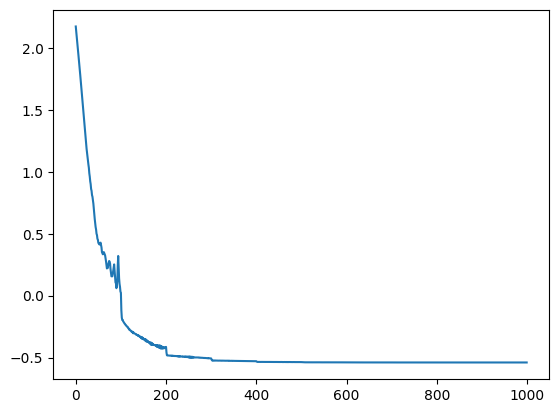

In [108]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [109]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-9.8145e-02, -1.3407e-01, -1.8942e-01, -1.0650e-01, -1.6449e-01,
         -1.7222e-01, -1.1341e-01, -1.0689e-01, -1.4121e-01, -9.8853e-02,
         -1.5770e-06, -5.8552e-06, -3.2022e-06,  3.2772e-03, -2.2124e-06,
         -8.6350e-07, -3.4506e-06,  9.4098e-07, -3.2854e-06,  4.4744e-07,
          1.0718e-06, -3.6425e-07, -3.9565e-07,  2.8560e-06, -2.2537e-06,
          3.9990e-07,  1.8886e-06,  2.4669e-06,  1.2185e-06, -7.7569e-08,
          2.1929e-06,  1.8528e-06,  5.5661e-07,  4.8725e-07,  1.9095e-06,
         -2.1416e-06, -2.7522e-06,  6.9222e-07, -1.9786e-06,  8.7994e-07,
          3.2482e-06, -8.7335e-07, -3.2121e-06, -3.5723e-06,  1.1142e-06,
          2.8836e-06,  2.0833e-06, -2.9173e-06, -5.1324e-08, -8.9452e-08,
          4.2531e-07, -1.7295e-06,  2.3960e-06,  3.8481e-06,  4.8320e-07,
          3.4119e-06,  1.9541e-06, -1.4936e-06, -5.6157e-07, -5.1055e-07,
         -1.1687e-07,  2.1647e-06,  3.1317e-04, -1.4382e-06, -1.9707e-06,
         -1.8908e-06, -1.6921e-07, -2.

tensor([[-9.8145e-02, -1.3407e-01, -1.8942e-01, -1.0650e-01, -1.6449e-01,
         -1.7222e-01, -1.1341e-01, -1.0689e-01, -1.4121e-01, -9.8853e-02,
         -1.5770e-06, -5.8552e-06, -3.2022e-06,  3.2772e-03, -2.2124e-06,
         -8.6350e-07, -3.4506e-06,  9.4098e-07, -3.2854e-06,  4.4744e-07,
          1.0718e-06, -3.6425e-07, -3.9565e-07,  2.8560e-06, -2.2537e-06,
          3.9990e-07,  1.8886e-06,  2.4669e-06,  1.2185e-06, -7.7569e-08,
          2.1929e-06,  1.8528e-06,  5.5661e-07,  4.8725e-07,  1.9095e-06,
         -2.1416e-06, -2.7522e-06,  6.9222e-07, -1.9786e-06,  8.7994e-07,
          3.2482e-06, -8.7335e-07, -3.2121e-06, -3.5723e-06,  1.1142e-06,
          2.8836e-06,  2.0833e-06, -2.9173e-06, -5.1324e-08, -8.9452e-08,
          4.2531e-07, -1.7295e-06,  2.3960e-06,  3.8481e-06,  4.8320e-07,
          3.4119e-06,  1.9541e-06, -1.4936e-06, -5.6157e-07, -5.1055e-07,
         -1.1687e-07,  2.1647e-06,  3.1317e-04, -1.4382e-06, -1.9707e-06,
         -1.8908e-06, -1.6921e-07, -2.

tensor([[-1.3286e-01, -1.7964e-01, -2.0997e-01, -1.4878e-01,  1.5976e-01,
         -2.5972e-01, -1.3434e-01, -1.4530e-01, -1.4083e-01, -1.4920e-01,
         -4.4588e-07, -3.1959e-08, -8.2894e-08,  3.1314e-02,  7.3431e-08,
         -9.1701e-09, -3.0765e-07,  5.9403e-07,  8.9817e-07,  2.8775e-09,
          3.0865e-08,  1.0377e-07, -6.5689e-08,  7.3557e-07,  4.4837e-07,
         -5.3586e-08,  4.2961e-07, -2.6926e-07, -6.4554e-08,  1.9213e-08,
          1.9463e-06, -1.3519e-08,  3.9988e-07, -1.6400e-08,  3.9163e-07,
         -1.5689e-07,  1.3572e-06,  2.8554e-08,  3.6866e-07, -3.0387e-07,
         -3.9460e-07,  1.3585e-09,  1.6906e-07, -4.8893e-07, -1.4177e-07,
         -4.3335e-08,  2.2945e-07,  5.3522e-08,  1.0407e-06, -6.6997e-08,
          7.1374e-08,  9.7862e-08, -3.0801e-07,  2.8128e-07,  8.0663e-08,
          9.4198e-08,  7.0048e-07,  1.5145e-06,  9.4534e-08, -5.3197e-07,
          3.9258e-07,  5.7709e-08, -3.6155e-02,  5.1754e-09, -6.3266e-07,
         -1.9294e-07,  2.1808e-08,  2.

In [110]:

model_1(test_x1)[0].squeeze()
model_2(test_x2)[0].squeeze()
model_3(test_x3)[0].squeeze()


tensor([9.8470e-01, 9.8580e-01, 1.3028e-01, 6.8596e-01, 3.1044e-03, 9.8489e-01,
        8.9257e-01, 5.0121e-02, 9.8185e-01, 9.1826e-01, 1.4346e-05, 9.8279e-01,
        9.9022e-01, 1.7881e-02, 5.5627e-01, 9.5144e-01, 9.3383e-02, 8.5466e-01,
        1.9977e-02, 1.6767e-02, 3.5444e-03, 9.6348e-01, 9.7325e-01, 5.4095e-01,
        8.1266e-01, 3.8382e-01, 2.5698e-01, 3.6676e-02, 5.6594e-01, 2.8607e-01,
        1.0316e-01, 1.5631e-01, 5.1326e-04, 4.0832e-01, 1.7773e-01, 5.8867e-01,
        9.2572e-01, 9.3516e-01, 2.6802e-01, 1.2607e-03],
       grad_fn=<SqueezeBackward0>)

tensor([7.2186e-02, 9.9635e-01, 6.2553e-02, 7.5975e-01, 7.9249e-01, 9.9279e-01,
        9.8610e-01, 9.8861e-01, 6.8292e-03, 8.2489e-01, 7.9016e-01, 9.8985e-01,
        1.9252e-07, 9.9851e-01, 2.1592e-01, 3.2519e-03, 9.9675e-01, 9.8016e-01,
        4.6351e-02, 8.7284e-01, 1.8526e-01, 4.7482e-01, 1.9980e-03, 5.7221e-08,
        7.5557e-01, 6.0929e-04, 8.2604e-02, 7.4863e-03, 2.0039e-01, 7.8892e-01,
        7.9309e-01, 6.2648e-02, 7.0040e-07, 1.2529e-01, 9.0172e-01, 9.9936e-01,
        9.6882e-01, 2.8840e-03, 9.9384e-01, 8.0109e-01],
       grad_fn=<SqueezeBackward0>)

tensor([3.9686e-01, 9.8754e-01, 9.7929e-01, 9.8417e-01, 4.4383e-03, 1.9885e-01,
        8.4793e-01, 6.5972e-02, 9.7331e-01, 9.7214e-01, 8.8816e-01, 1.3930e-01,
        9.9250e-01, 7.0682e-01, 9.9082e-01, 1.2982e-01, 9.9100e-01, 9.6245e-01,
        9.8351e-01, 9.9060e-01, 8.0404e-01, 7.0020e-01, 9.0362e-01, 9.5016e-01,
        1.0593e-01, 1.9460e-02, 1.7163e-03, 9.8880e-01, 5.5399e-01, 9.8000e-01,
        8.2084e-01, 2.6502e-04, 9.4373e-01, 9.5021e-01, 2.8929e-03, 3.9834e-02,
        3.6538e-01, 9.3700e-01, 6.2354e-01, 4.1113e-02],
       grad_fn=<SqueezeBackward0>)

In [111]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[42,  9],
       [11, 58]])

0.8405797101449275

0.8235294117647058

0.8333333333333334

0.8656716417910447

0.8529411764705882

In [112]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[17,  1],
       [ 3, 19]])

0.8636363636363636

0.9444444444444444

array([[11,  4],
       [ 8, 17]])

0.68

0.7333333333333333

array([[14,  4],
       [ 0, 22]])

1.0

0.7777777777777778

In [91]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_2_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_3_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-9.59096178e-02, -1.21017687e-01, -1.79904476e-01,
        -1.06644273e-01, -1.44619480e-01, -1.78786620e-01,
        -1.05820209e-01, -1.09705493e-01, -1.31237209e-01,
        -7.68972784e-02, -3.31100528e-05, -3.59764730e-04,
         3.20586041e-05,  5.38242282e-03,  1.65707635e-04,
         1.72349668e-04,  3.58476718e-05, -1.63577730e-04,
         3.27000089e-05, -2.35994885e-04, -1.46231163e-04,
        -5.00681163e-05, -3.77871547e-05,  1.96107547e-04,
         8.43572707e-05,  5.80130654e-05, -2.93406902e-05,
        -8.79265426e-05,  1.20717959e-04,  1.42280056e-04,
         1.97402827e-04,  2.39783825e-04,  2.87645908e-05,
        -6.24669556e-05, -6.06268950e-05,  2.03887976e-04,
         9.59850950e-05,  4.93601183e-05, -1.08939006e-04,
         1.16650175e-04, -1.23129314e-04, -3.13183627e-05,
        -2.31755344e-04, -5.36000625e-05,  2.24794043e-04,
         1.90570674e-04, -1.23035323e-04,  3.45410554e-05,
         8.47969350e-05,  5.69178928e-06, -3.56247438e-0

array([[-9.59096178e-02, -1.21017687e-01, -1.79904476e-01,
        -1.06644273e-01, -1.44619480e-01, -1.78786620e-01,
        -1.05820209e-01, -1.09705493e-01, -1.31237209e-01,
        -7.68972784e-02, -3.31100528e-05, -3.59764730e-04,
         3.20586041e-05,  5.38242282e-03,  1.65707635e-04,
         1.72349668e-04,  3.58476718e-05, -1.63577730e-04,
         3.27000089e-05, -2.35994885e-04, -1.46231163e-04,
        -5.00681163e-05, -3.77871547e-05,  1.96107547e-04,
         8.43572707e-05,  5.80130654e-05, -2.93406902e-05,
        -8.79265426e-05,  1.20717959e-04,  1.42280056e-04,
         1.97402827e-04,  2.39783825e-04,  2.87645908e-05,
        -6.24669556e-05, -6.06268950e-05,  2.03887976e-04,
         9.59850950e-05,  4.93601183e-05, -1.08939006e-04,
         1.16650175e-04, -1.23129314e-04, -3.13183627e-05,
        -2.31755344e-04, -5.36000625e-05,  2.24794043e-04,
         1.90570674e-04, -1.23035323e-04,  3.45410554e-05,
         8.47969350e-05,  5.69178928e-06, -3.56247438e-0

array([[-1.3575754e-01, -1.5152168e-01, -2.1447752e-01, -1.4928494e-01,
         1.3978471e-01, -2.6241198e-01, -1.2952955e-01, -1.4493278e-01,
        -1.3621576e-01, -1.1110130e-01, -2.4105568e-06,  2.2520406e-05,
         1.9297399e-06,  3.3326037e-02,  6.4229360e-05, -4.9040726e-05,
         5.4687407e-06, -4.0674007e-05,  7.1951895e-06, -6.1815040e-06,
        -2.0326718e-07, -3.4135155e-05, -6.4325791e-06,  1.6619255e-05,
         4.5659941e-05,  3.7630748e-06,  2.0820951e-05, -4.4398312e-05,
         5.6542067e-06,  6.1527675e-07,  1.8851064e-05,  1.0011159e-05,
         2.0926862e-05,  5.9117219e-06,  2.1113312e-05, -2.5865888e-06,
         1.9977203e-06, -3.1737436e-05,  6.7038986e-06, -7.0697897e-06,
         6.0892812e-06, -8.7005276e-07,  1.0258558e-05, -1.6040555e-06,
         1.1807156e-05,  2.3004699e-05, -7.0722608e-06, -1.9484710e-06,
         1.5764319e-05, -2.0372179e-06, -6.2969696e-07,  3.3514953e-06,
        -4.1866933e-05,  7.4684708e-06, -2.3929654e-06,  1.43173

In [92]:
threshold=0.15
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.09590962, -0.12101769, -0.17990448, -0.10664427, -0.14461948,
        -0.17878662, -0.10582021, -0.10970549, -0.13123721, -0.07689728,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

10